# LayerCAM Calculation for Baseline Models
use the second cell for B-Cos networks because they require different preprocessing

In [1]:
import os
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import ResNet50_Weights, resnet50
from torchvision import models, transforms


from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import numpy as np
import pandas as pd
from torchvision.transforms import functional as TF
from PIL import Image
from libraries.bcosconv2d import NormedConv2d
import pydicom 
import random
import matplotlib.pyplot as plt

from collections import OrderedDict

from libraries.bcosconv2d import NormedConv2d
from pooling.flc_bcosconv2d import ModifiedFLCBcosConv2d

from cam.layercam import LayerCAM
from dataset.augmentations import no_augmentations
from libraries.energyPointGame import energy_point_game


np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

class PneumoniaDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None):
        self.data = dataframe
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_folder, f"{row['patientId']}.dcm")
        label = row['Target']
        patient_id = row['patientId']

        # Load DICOM file and process it into RGB format
        dicom = pydicom.dcmread(image_path)
        image = dicom.pixel_array
        image = Image.fromarray(image).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long), patient_id



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

original_width, original_height = 1024, 1024
explanation_width, explanation_height = 224, 224

image_folder = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_images"
model_path = r"C:\Users\Admin\Documents\MasterThesis\results\ResNet50_Baseline\oversampling_light\seed_0\pneumonia_detection_model_resnet_baseline_bestf1_1.pth"
#model_path = r"C:\Users\Admin\Documents\MasterThesis\results\ResNet_BCos\seed_0\pneumonia_detection_model_resnet_bcos_bestf1_1_26.pth"

csv_path_splits = r"G:\Meine Ablage\Universität\Master Thesis\Pneumonia\training\grouped_data.csv"
csv_path = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_labels.csv"
splits_path = r"G:\Meine Ablage\Universität\Master Thesis\Pneumonia\training\splits\splits_balanced_fix.pkl"

model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 2)  # Binary classification

#model = torch.hub.load('B-cos/B-cos-v2', 'resnet50', pretrained=True)
#model.fc.linear = NormedConv2d(2048, 2, kernel_size=(1, 1), stride=(1, 1), bias=False) # code from B-cos paper reused to adjust network

state_dict = torch.load(model_path)
model.load_state_dict(state_dict)
model.to(device)


scale_x = explanation_width / original_width
scale_y = explanation_height / original_height


data = pd.read_csv(csv_path)
data_splits = pd.read_csv(csv_path_splits)
with open(splits_path, 'rb') as f:
    splits = pickle.load(f)

# Loop over whole validation set of first fold 
first_split = splits[0] # fold selection
val_idx = first_split[1]  # Only use the validation indices from the first fold
val_data = data_splits.iloc[val_idx]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor() # Normalize with ImageNet stats
])

    

val_dataset = PneumoniaDataset(val_data, image_folder, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


model_dict = dict(
    type="resnet_base",
    layer_name="layer4",
    arch=model,
    target_layer=model.layer4[-1].conv2 # Example: last layer of ResNet's layer4  ###### IN BCOS:     target_layer=model.layer4[-1].conv3  # Example: last layer of ResNet's layer4  ### double check!

)

cam = LayerCAM(model_dict)
proportions = []
proportions_correct = []
proportions_incorrect = []
count_correct = 0
count_incorrect = 0
model.eval()
for images, labels, patient_ids in val_loader:
    with torch.set_grad_enabled(True):
        images, labels = images.to(device), labels.to(device)
        #six_channel_images = []
        #for img_tensor in images:
        #    numpy_image = (img_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
        #    pil_image = Image.fromarray(numpy_image)
        #    transformed_image = model.transform(pil_image)
        #    six_channel_images.append(transformed_image)
        #six_channel_images = torch.stack(six_channel_images).to(device)
        for image, label, patient_id in zip(images, labels, patient_ids): #zip(images, labels, patient_ids):
            filtered_rows = data[(data['patientId'] == patient_id) & (data['Target'] == 1)]
            if not filtered_rows.empty:   
                #image = image[None]
                image = image.unsqueeze(0)
                output = model(image) 
                prediction = torch.argmax(output, dim=1)

                contribution_map = cam(image, class_idx=1).cpu()
                proportion = 0.0
                for _, row in filtered_rows.iterrows():
                    x, y, width, height = round(row["x"] * scale_x), round(row["y"] * scale_y), round(row["width"] * scale_x), round(row["height"] * scale_y)
                    #x, y, width, height = row["x"], row["y"], row["width"], row["height"]
                    coordinates_list = [x, y, x + width, y + height]
                    coordinates_tensor = torch.tensor(coordinates_list, dtype=torch.int32)
                    #print(contribution_map)
                    contribution_map_2d = contribution_map.squeeze(0).squeeze(0)
                    #plt.imshow(contribution_map.squeeze(0).squeeze(0).cpu().numpy(), cmap='jet', alpha=0.5)
                    #plt.colorbar()
                    #plt.title(f"LayerCAM Heatmap for Patient {patient_id}")
                    #plt.show()
                    proportion += energy_point_game(coordinates_tensor, contribution_map_2d)
                        
                proportions.append(proportion)
                if prediction == 1:
                    proportions_correct.append(proportion)
                    count_correct = count_correct + 1
                    #print("Proportion Correct " + str(proportion.item()))
                else:
                    proportions_incorrect.append(proportion)
                    #print("Proportion: Incorrect" + str(proportion.item()))
                    count_incorrect = count_incorrect + 1
                
if proportions:
    avg_proportion = sum(proportions) / len(proportions)
    avg_proportion_incorrect = sum(proportions_incorrect) / len(proportions_incorrect)
    avg_proportion_correct = sum(proportions_correct) / len(proportions_correct)
    
    avg_proportion = round(avg_proportion.item(), 4)
    avg_proportion_incorrect = round(avg_proportion_incorrect.item(), 4)
    avg_proportion_correct = round(avg_proportion_correct.item(), 4)

    print(f"Average LayerCAM Energy-Based Pointing Game Proportion: {avg_proportion}")
    print(f"Average LayerCAM Energy-Based Pointing Game Proportion of Incorrectly Classified Images: {avg_proportion_incorrect}, Count: {count_incorrect}")
    print(f"Average LayerCAM Energy-Based Pointing Game Proportion of Correctly Classified Images: {avg_proportion_correct}, Count: {count_correct}")

else:
    print("No valid proportions were found.")   





FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Admin\\Documents\\MasterThesis\\results\\ResNet50_Baseline\\oversampling_light\\seed_0\\pneumonia_detection_model_resnet_baseline_bestf1_1.pth'

# LayerCAM for B-Cos Models
execute the line below 

In [3]:
import os
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import ResNet50_Weights, resnet50
from torchvision import models, transforms


from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import numpy as np
import pandas as pd
from torchvision.transforms import functional as TF
from PIL import Image
from libraries.bcosconv2d import NormedConv2d
import pydicom 
import random
import matplotlib.pyplot as plt

from collections import OrderedDict

from libraries.bcosconv2d import NormedConv2d
from pooling.flc_bcosconv2d import ModifiedFLCBcosConv2d

from cam.layercam import LayerCAM
from dataset.augmentations import no_augmentations
from libraries.energyPointGame import energy_point_game


np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

class PneumoniaDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None):
        self.data = dataframe
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_folder, f"{row['patientId']}.dcm")
        label = row['Target']
        patient_id = row['patientId']

        # Load DICOM file and process it into RGB format
        dicom = pydicom.dcmread(image_path)
        image = dicom.pixel_array
        image = Image.fromarray(image).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long), patient_id



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

original_width, original_height = 1024, 1024
explanation_width, explanation_height = 224, 224

image_folder = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_images"
model_path = r"C:\Users\Admin\Documents\MasterThesis\results\Pneumonia\ResNet50_BCos\no_nosamp\seed_0\pneumonia_detection_model_resnet_bestf1_2.pth"
csv_path_splits = r"G:\Meine Ablage\Universität\Master Thesis\Pneumonia\training\grouped_data.csv"
csv_path = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_labels.csv"
splits_path = r"G:\Meine Ablage\Universität\Master Thesis\Pneumonia\training\splits\splits_balanced_fix.pkl"

model = torch.hub.load('B-cos/B-cos-v2', 'resnet50', pretrained=True)
model.fc.linear = NormedConv2d(2048, 2, kernel_size=(1, 1), stride=(1, 1), bias=False) # code from B-cos paper reused to adjust network

state_dict = torch.load(model_path)
model.load_state_dict(state_dict)
model.to(device)


scale_x = explanation_width / original_width
scale_y = explanation_height / original_height


data = pd.read_csv(csv_path)
data_splits = pd.read_csv(csv_path_splits)
with open(splits_path, 'rb') as f:
    splits = pickle.load(f)

# Loop over whole validation set of first fold 
first_split = splits[1] # fold selection
val_idx = first_split[1]  # Only use the validation indices from the first fold
val_data = data_splits.iloc[val_idx]

transform = transforms.Compose([
    transforms.ToTensor() # Normalize with ImageNet stats
])

    

val_dataset = PneumoniaDataset(val_data, image_folder, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


model_dict = dict(
    type="resnet_bcos",
    layer_name="layer4",
    arch=model,
    target_layer=model.layer4[-1].conv3 # Example: last layer of ResNet's layer4  ###### IN BCOS:     target_layer=model.layer4[-1].conv3  # Example: last layer of ResNet's layer4  ### double check!

)

cam = LayerCAM(model_dict)
proportions = []
proportions_correct = []
proportions_incorrect = []
count_correct = 0
count_incorrect = 0
model.eval()
with torch.set_grad_enabled(True):
    for images, labels, patient_ids in val_loader:
            images, labels = images.to(device), labels.to(device)
            six_channel_images = []
            for img_tensor in images:
                numpy_image = (img_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
                pil_image = Image.fromarray(numpy_image)
                transformed_image = model.transform(pil_image)
                six_channel_images.append(transformed_image)
            six_channel_images = torch.stack(six_channel_images).to(device)
            for image, label, patient_id in zip(six_channel_images, labels, patient_ids): #zip(images, labels, patient_ids):
                filtered_rows = data[(data['patientId'] == patient_id) & (data['Target'] == 1)]
                if not filtered_rows.empty:   
                    image = image.unsqueeze(0)
                    output = model(image) 
                    prediction = torch.argmax(output, dim=1)

                    contribution_map = cam(image, class_idx=1).cpu()
                    proportion = 0.0
                    for _, row in filtered_rows.iterrows():
                        x, y, width, height = round(row["x"] * scale_x), round(row["y"] * scale_y), round(row["width"] * scale_x), round(row["height"] * scale_y)
                        #x, y, width, height = row["x"], row["y"], row["width"], row["height"]
                        coordinates_list = [x, y, x + width, y + height]
                        coordinates_tensor = torch.tensor(coordinates_list, dtype=torch.int32)
                        #print(contribution_map)
                        contribution_map_2d = contribution_map.squeeze(0).squeeze(0)
                        #plt.imshow(contribution_map.squeeze(0).squeeze(0).cpu().numpy(), cmap='jet', alpha=0.5)
                        #plt.colorbar()
                        #plt.title(f"LayerCAM Heatmap for Patient {patient_id}")
                        #plt.show()
                        proportion += energy_point_game(coordinates_tensor, contribution_map_2d)
                            
                    proportions.append(proportion)
                    if prediction == 1:
                        proportions_correct.append(proportion)
                        count_correct = count_correct + 1
                        #print("Proportion Correct " + str(proportion.item()))
                    else:
                        proportions_incorrect.append(proportion)
                        #print("Proportion: Incorrect" + str(proportion.item()))
                        count_incorrect = count_incorrect + 1
                    
    if proportions:
        avg_proportion = sum(proportions) / len(proportions)
        avg_proportion_incorrect = sum(proportions_incorrect) / len(proportions_incorrect)
        avg_proportion_correct = sum(proportions_correct) / len(proportions_correct)
            
        avg_proportion = round(avg_proportion.item(), 4)
        avg_proportion_incorrect = round(avg_proportion_incorrect.item(), 4)
        avg_proportion_correct = round(avg_proportion_correct.item(), 4)

        print(f"Average LayerCAM Energy-Based Pointing Game Proportion: {avg_proportion}")
        print(f"Average LayerCAM Energy-Based Pointing Game Proportion of Incorrectly Classified Images: {avg_proportion_incorrect}, Count: {count_incorrect}")
        print(f"Average LayerCAM Energy-Based Pointing Game Proportion of Correctly Classified Images: {avg_proportion_correct}, Count: {count_correct}")

    else:
        print("No valid proportions were found.")   





Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Average LayerCAM Energy-Based Pointing Game Proportion: 0.0988
Average LayerCAM Energy-Based Pointing Game Proportion of Incorrectly Classified Images: 0.0552, Count: 504
Average LayerCAM Energy-Based Pointing Game Proportion of Correctly Classified Images: 0.1302, Count: 698


In [ ]:
from libraries.energyPointGame import energy_point_game, energy_point_game_recall
from libraries.bcosconv2d import NormedConv2d

import random
import numpy as np
import torch
import pandas as pd
import pydicom
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import pickle
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from libraries.bcosconv2d import NormedConv2d
from blurpool.blur_bcosconv2d import ModifiedBcosConv2d
from pooling.flc_bcosconv2d import ModifiedFLCBcosConv2d
from libraries.bcoslinear import BcosLinear
from cam.layercam import LayerCAM


original_width, original_height = 1024, 1024
explanation_width, explanation_height = 224, 224

image_folder = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_images"
csv_path_splits = r"G:\Meine Ablage\Universität\Master Thesis\Pneumonia\training\grouped_data.csv"
csv_path = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_labels.csv"
splits_path = r"G:\Meine Ablage\Universität\Master Thesis\Pneumonia\training\splits\splits_balanced_fix.pkl"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = pd.read_csv(csv_path)
data_splits = pd.read_csv(csv_path_splits)

with open(splits_path, 'rb') as f:
    splits = pickle.load(f)

scale_x = explanation_width / original_width
scale_y = explanation_height / original_height

class PneumoniaDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None):
        self.data = dataframe
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_folder, f"{row['patientId']}.dcm")
        label = row['Target']
        patient_id = row['patientId']

        # Load DICOM file and process it into RGB format
        dicom = pydicom.dcmread(image_path)
        image = dicom.pixel_array
        image = Image.fromarray(image).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long), patient_id


transform = transforms.Compose([
    transforms.ToTensor()# Normalize with ImageNet stats
])

seeds = [0, 1]
all_results = []

for seed in seeds:
    print(f"\n{'='*40}")
    print(f"Processing seed {seed}")
    print(f"{'='*40}\n")
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    
    avg_proportions = []
    avg_proportions_incorrect = []
    avg_proportions_correct = []

    for fold in range(1,6):
        
        #model_path = r"C:\Users\Admin\Documents\MasterThesis\results\Pneumonia\ResNet50_BCos\no_nosamp\seed_0\pneumonia_detection_model_resnet_bestf1_2.pth"

        model_path = f"C:/Users/Admin/Documents/MasterThesis/results/Pneumonia/ResNet50_Baseline/no_nosamp/seed_{seed}/pneumonia_detection_model_resnet_bestf1_{fold}.pth"        
        split = splits[fold-1] # fold selection
        val_idx = split[1] 
        val_data = data_splits.iloc[val_idx]
        val_dataset = PneumoniaDataset(val_data, image_folder, transform=transform)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

        proportions = []
        proportions_correct = []
        proportions_incorrect = []
        count_correct = 0
        count_incorrect = 0
        
        model = torch.hub.load('B-cos/B-cos-v2', 'resnet50', pretrained=True)
        model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        model.fc = nn.Linear(model.fc.in_features, 2)  # Binary classification
        
        state_dict = torch.load(model_path)
        model.load_state_dict(state_dict)
        model.to(device)

        model_dict = dict(
            type="resnet_bcos",
            layer_name="layer4",
            arch=model,
            target_layer=model.layer4[-1].conv3 # Example: last layer of ResNet's layer4  ###### IN BCOS:     target_layer=model.layer4[-1].conv3  # Example: last layer of ResNet's layer4  ### double check!

        )

        cam = LayerCAM(model_dict)

        model.eval()
        with torch.set_grad_enabled(True):
                
            for images, labels, patient_ids in val_loader:
                #images, labels = images.to(device), labels.to(device)
                labels = labels.to(device)
                six_channel_images = []
                for img_tensor in images:
                    numpy_image = (img_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
                    pil_image = Image.fromarray(numpy_image)
                    transformed_image = model.transform(pil_image)
                    six_channel_images.append(transformed_image)
                    
                six_channel_images = torch.stack(six_channel_images).to(device)
                
                for image, label, patient_id in zip(six_channel_images, labels, patient_ids):
                    filtered_rows = data[(data['patientId'] == patient_id) & (data['Target'] == 1)]
                    if not filtered_rows.empty: 
                        image = image.unsqueeze(0)
                        output = model(image) 
                        prediction = torch.argmax(output, dim=1)

                        #contribution_map = cam(image).cpu()
                        contribution_map = cam(image, class_idx=1).cpu()
                        
                        proportion = 0.0
                        for _, row in filtered_rows.iterrows():
                            x, y, width, height = round(row["x"] * scale_x), round(row["y"] * scale_y), round(row["width"] * scale_x), round(row["height"] * scale_y)
                            coordinates_list = [x, y, x + width, y + height]
                            coordinates_tensor = torch.tensor(coordinates_list, dtype=torch.int32)
                            contribution_map_2d = contribution_map.squeeze(0).squeeze(0)
                            ebpg_result = energy_point_game(coordinates_tensor, contribution_map_2d)
                            proportion += ebpg_result
                            
                        proportions.append(proportion)
                        if prediction == 1:
                            proportions_correct.append(proportion)
                            count_correct = count_correct + 1
                        else:
                            proportions_incorrect.append(proportion)
                            count_incorrect = count_incorrect + 1
        if proportions:
            avg_proportion = sum(proportions) / len(proportions)
            avg_proportion_incorrect = sum(proportions_incorrect) / len(proportions_incorrect)
            avg_proportion_correct = sum(proportions_correct) / len(proportions_correct)
            avg_proportions.append(avg_proportion)
            avg_proportions_incorrect.append(avg_proportion_incorrect)
            avg_proportions_correct.append(avg_proportion_correct)

        avg_proportion = round(avg_proportion.item(), 4)
        avg_proportion_incorrect = round(avg_proportion_incorrect.item(), 4)
        avg_proportion_correct = round(avg_proportion_correct.item(), 4)
        
        print(f"Average Energy-Based Pointing Game Proportion (Positive): {avg_proportion}")
        print(f"Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: {avg_proportion_incorrect}, Count: {count_incorrect}", flush=True)
        print(f"Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: {avg_proportion_correct}, Count: {count_correct}", flush=True)



    final_avg_prop = sum(avg_proportions) / len(avg_proportions) 
    final_avg_prop_incorrect = sum(avg_proportions_incorrect) / len(avg_proportions_incorrect)
    final_avg_prop_correct = sum(avg_proportions_correct) / len(avg_proportions_correct)

    final_avg_prop = round(final_avg_prop.item(), 4)
    final_avg_prop_incorrect = round(final_avg_prop_incorrect.item(), 4)
    final_avg_prop_correct = round(final_avg_prop_correct.item(), 4)
    print(f"Average Energy-Based Pointing Game Proportion (Positive) over all folds: {final_avg_prop}", flush=True)
    print(f"Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images over all folds: {final_avg_prop_incorrect}", flush=True)
    print(f"Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images over all folds: {final_avg_prop_correct}", flush=True)

        
        # Store results per fold with seed information
    fold_results = {
        'seed': seed,
        'fold': fold,
        'avg_proportion': final_avg_prop,
        'avg_incorrect': final_avg_prop_incorrect,
        'avg_correct': final_avg_prop_correct,
    }
    all_results.append(fold_results)

# Calculate aggregate statistics
def calculate_stats(values):
    return f"{np.mean(values):.4f} ± {np.std(values):.4f}"

final_proportions = [r['avg_proportion'] for r in all_results]
final_incorrect = [r['avg_incorrect'] for r in all_results]
final_correct = [r['avg_correct'] for r in all_results]

print("\n\n=== Final Aggregate Statistics ===")
print(f"Overall EPG (Positive): {calculate_stats(final_proportions)}")
print(f"EPG Incorrect Classifications: {calculate_stats(final_incorrect)}")
print(f"EPG Correct Classifications: {calculate_stats(final_correct)}")



Processing seed 0



Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


AttributeError: 'ResNet' object has no attribute 'transform'

In [ ]:
from libraries.energyPointGame import energy_point_game, energy_point_game_recall
from libraries.bcosconv2d import NormedConv2d

import random
import numpy as np
import torch
import pandas as pd
import pydicom
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import pickle
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from libraries.bcosconv2d import NormedConv2d
from blurpool.blur_bcosconv2d import ModifiedBcosConv2d
from pooling.flc_bcosconv2d import ModifiedFLCBcosConv2d
from libraries.bcoslinear import BcosLinear
from cam.layercam import LayerCAM
from torchvision.models import ResNet50_Weights, resnet50
from torchvision import models, transforms
import torch.nn as nn



original_width, original_height = 1024, 1024
explanation_width, explanation_height = 224, 224

image_folder = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_images"
csv_path_splits = r"G:\Meine Ablage\Universität\Master Thesis\Pneumonia\training\grouped_data.csv"
csv_path = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_labels.csv"
splits_path = r"G:\Meine Ablage\Universität\Master Thesis\Pneumonia\training\splits\splits_balanced_fix.pkl"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = pd.read_csv(csv_path)
data_splits = pd.read_csv(csv_path_splits)

with open(splits_path, 'rb') as f:
    splits = pickle.load(f)

scale_x = explanation_width / original_width
scale_y = explanation_height / original_height

class PneumoniaDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None):
        self.data = dataframe
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_folder, f"{row['patientId']}.dcm")
        label = row['Target']
        patient_id = row['patientId']

        # Load DICOM file and process it into RGB format
        dicom = pydicom.dcmread(image_path)
        image = dicom.pixel_array
        image = Image.fromarray(image).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long), patient_id


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

seeds = [0, 1]
all_results = []

for seed in seeds:
    print(f"\n{'='*40}")
    print(f"Processing seed {seed}")
    print(f"{'='*40}\n")
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    
    avg_proportions = []
    avg_proportions_incorrect = []
    avg_proportions_correct = []

    for fold in range(1,6):
        
        #model_path = r"C:\Users\Admin\Documents\MasterThesis\results\Pneumonia\ResNet50_BCos\no_nosamp\seed_0\pneumonia_detection_model_resnet_bestf1_2.pth"

        model_path = f"C:/Users/Admin/Documents/MasterThesis/results/Pneumonia/ResNet50_Baseline/light_oversamp/seed_{seed}/pneumonia_detection_model_resnet_bestf1_{fold}.pth"        
        split = splits[fold-1] # fold selection
        val_idx = split[1] 
        val_data = data_splits.iloc[val_idx]
        val_dataset = PneumoniaDataset(val_data, image_folder, transform=transform)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

        proportions = []
        proportions_correct = []
        proportions_incorrect = []
        count_correct = 0
        count_incorrect = 0
        
        model = torch.hub.load('B-cos/B-cos-v2', 'resnet50', pretrained=True)
        model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        model.fc = nn.Linear(model.fc.in_features, 2)  # Binary classification
        
        state_dict = torch.load(model_path)
        model.load_state_dict(state_dict)
        model.to(device)

        model_dict = dict(
            type="resnet50",
            layer_name="layer4",
            arch=model,
            target_layer=model.layer4[2].conv3 # Example: last layer of ResNet's layer4  ###### IN BCOS:     target_layer=model.layer4[-1].conv3  # Example: last layer of ResNet's layer4  ### double check!

        )

        cam = LayerCAM(model_dict)

        with torch.set_grad_enabled(True):
            for images, labels, patient_ids in val_loader:
                #images, labels = images.to(device), labels.to(device)
                images, labels = images.to(device), labels.to(device)
                
                for image, label, patient_id in zip(images, labels, patient_ids):
                    filtered_rows = data[(data['patientId'] == patient_id) & (data['Target'] == 1)]
                    if not filtered_rows.empty: 
                        image = image.unsqueeze(0)
                        output = model(image) 
                        prediction = torch.argmax(output, dim=1)

                        #contribution_map = cam(image).cpu()
                        contribution_map = cam(image, class_idx=1).cpu()
                        
                        proportion = 0.0
                        for _, row in filtered_rows.iterrows():
                            x, y, width, height = round(row["x"] * scale_x), round(row["y"] * scale_y), round(row["width"] * scale_x), round(row["height"] * scale_y)
                            coordinates_list = [x, y, x + width, y + height]
                            coordinates_tensor = torch.tensor(coordinates_list, dtype=torch.int32)
                            contribution_map_2d = contribution_map.squeeze(0).squeeze(0)
                            ebpg_result = energy_point_game(coordinates_tensor, contribution_map_2d)
                            proportion += ebpg_result
                            
                        proportions.append(proportion)
                        if prediction == 1:
                            proportions_correct.append(proportion)
                            count_correct = count_correct + 1
                        else:
                            proportions_incorrect.append(proportion)
                            count_incorrect = count_incorrect + 1
        if proportions:
            avg_proportion = sum(proportions) / len(proportions)
            avg_proportion_incorrect = sum(proportions_incorrect) / len(proportions_incorrect)
            avg_proportion_correct = sum(proportions_correct) / len(proportions_correct)
            avg_proportions.append(avg_proportion)
            avg_proportions_incorrect.append(avg_proportion_incorrect)
            avg_proportions_correct.append(avg_proportion_correct)

        avg_proportion = round(avg_proportion.item(), 4)
        avg_proportion_incorrect = round(avg_proportion_incorrect.item(), 4)
        avg_proportion_correct = round(avg_proportion_correct.item(), 4)
        
        print(f"Average Energy-Based Pointing Game Proportion (Positive): {avg_proportion}")
        print(f"Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images: {avg_proportion_incorrect}, Count: {count_incorrect}", flush=True)
        print(f"Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images: {avg_proportion_correct}, Count: {count_correct}", flush=True)



    final_avg_prop = sum(avg_proportions) / len(avg_proportions) 
    final_avg_prop_incorrect = sum(avg_proportions_incorrect) / len(avg_proportions_incorrect)
    final_avg_prop_correct = sum(avg_proportions_correct) / len(avg_proportions_correct)

    final_avg_prop = round(final_avg_prop.item(), 4)
    final_avg_prop_incorrect = round(final_avg_prop_incorrect.item(), 4)
    final_avg_prop_correct = round(final_avg_prop_correct.item(), 4)
    print(f"Average Energy-Based Pointing Game Proportion (Positive) over all folds: {final_avg_prop}", flush=True)
    print(f"Average Energy-Based Pointing Game Proportion (Positive) of Incorrectly Classified Images over all folds: {final_avg_prop_incorrect}", flush=True)
    print(f"Average Energy-Based Pointing Game Proportion (Positive) of Correctly Classified Images over all folds: {final_avg_prop_correct}", flush=True)

        
        # Store results per fold with seed information
    fold_results = {
        'seed': seed,
        'fold': fold,
        'avg_proportion': final_avg_prop,
        'avg_incorrect': final_avg_prop_incorrect,
        'avg_correct': final_avg_prop_correct,
    }
    all_results.append(fold_results)

# Calculate aggregate statistics
def calculate_stats(values):
    return f"{np.mean(values):.4f} ± {np.std(values):.4f}"

final_proportions = [r['avg_proportion'] for r in all_results]
final_incorrect = [r['avg_incorrect'] for r in all_results]
final_correct = [r['avg_correct'] for r in all_results]

print("\n\n=== Final Aggregate Statistics ===")
print(f"Overall EPG (Positive): {calculate_stats(final_proportions)}")
print(f"EPG Incorrect Classifications: {calculate_stats(final_incorrect)}")
print(f"EPG Correct Classifications: {calculate_stats(final_correct)}")



Processing seed 0



Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


Attention(
  (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attend): Softmax(dim=-1)
  (to_qkv): Linear(in_features=768, out_features=2304, bias=False)
  (to_out): Linear(in_features=768, out_features=768, bias=False)
)
odict_keys(['encoder_0', 'encoder_1', 'encoder_2', 'encoder_3', 'encoder_4', 'encoder_5', 'encoder_6', 'encoder_7', 'encoder_8', 'encoder_9', 'encoder_10'])


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ..\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


AttributeError: 'LayerCAM' object has no attribute 'reshape_transform'

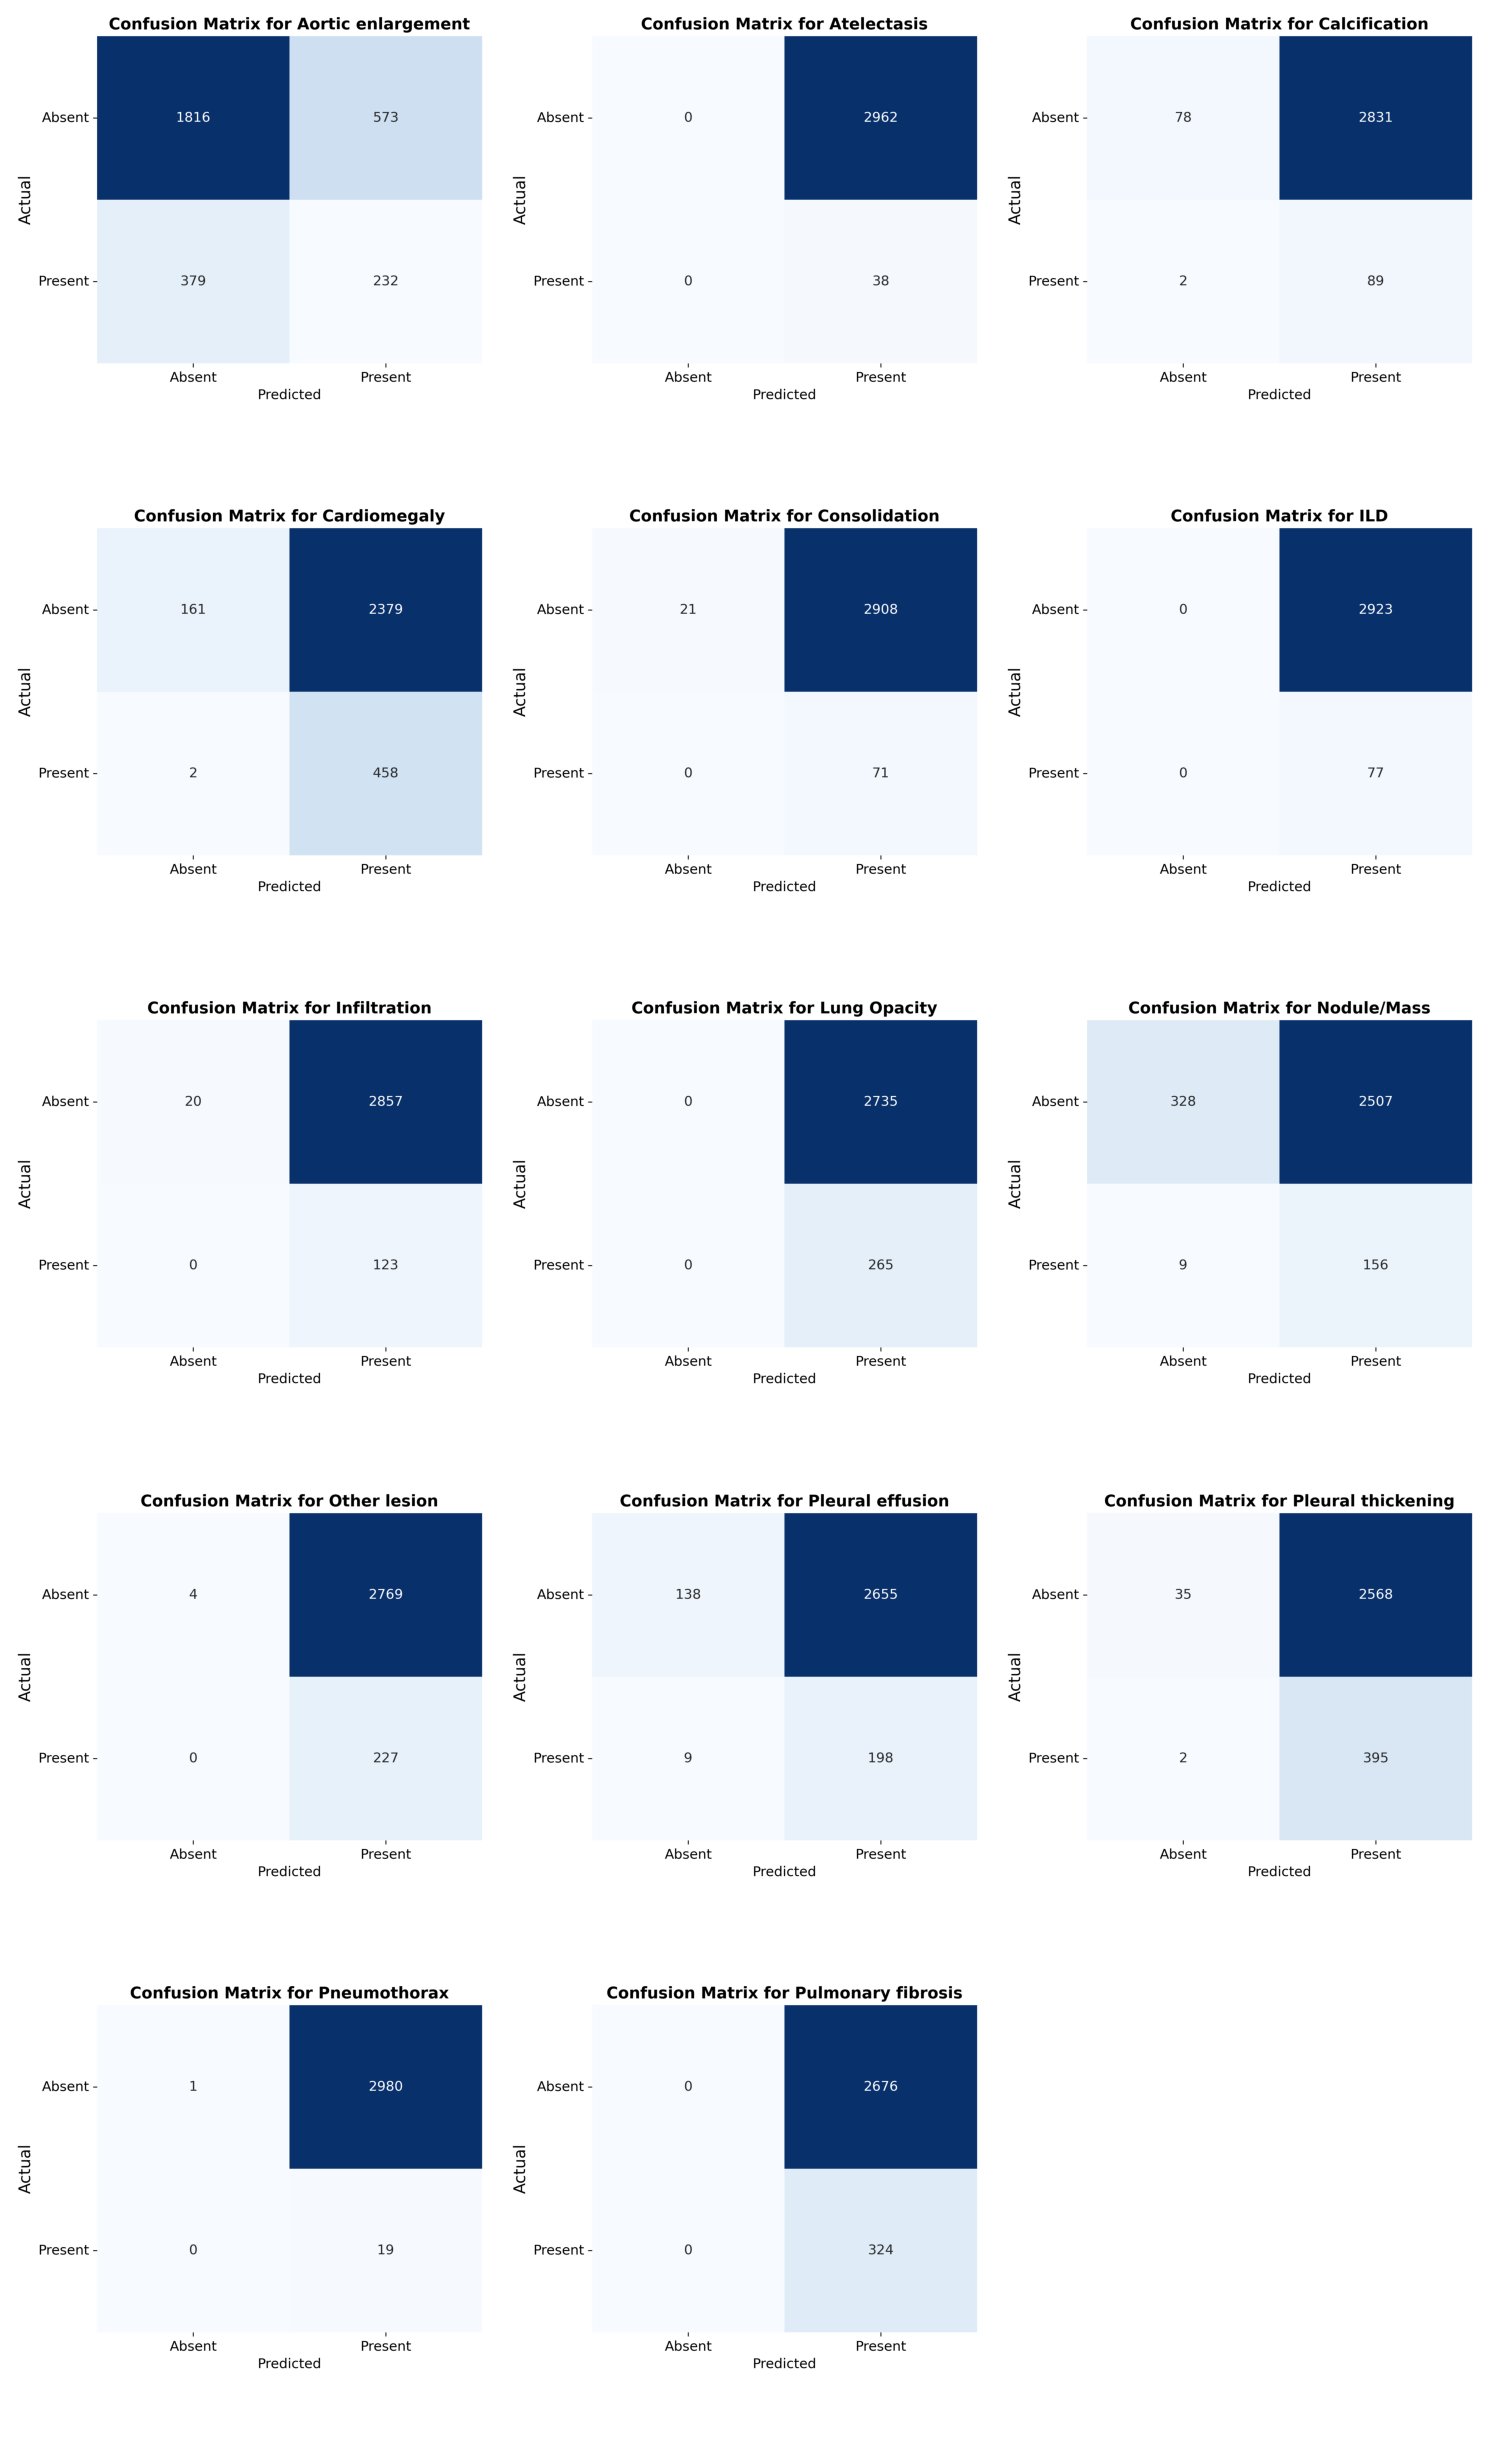

In [7]:
import os
from PIL import Image
import matplotlib.pyplot as plt

folder_path = r'C:\Users\Admin\Downloads\wah'

# Alle passenden Dateien sortiert auflisten
image_files = sorted([f for f in os.listdir(folder_path) if f.startswith('confusion_matrix_')])[:14]

# Bilder laden
images = [Image.open(os.path.join(folder_path, f)) for f in image_files]

# Anzahl der Spalten und Reihen berechnen
cols = 3
rows = (len(images) + cols - 1) // cols  # Aufrunden

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))

for idx, ax in enumerate(axes.flat):
    if idx < len(images):
        ax.imshow(images[idx])
        ax.axis('off')
    else:
        ax.axis('off')  # Leere Felder ausblenden

plt.tight_layout()
plt.show()


